In [1]:
!ls

 filesharing			 memo_cls	     Total-Text
 Memo_Classifier_pytorch.ipynb	'torch seti.ipynb'   volo


In [2]:
# Import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
from sklearn import metrics
# Import PyTorch packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import os, random, shutil

import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.loss import _WeightedLoss

import seaborn as sns
sns.set_style("darkgrid")
from torchvision import models 
from sklearn.metrics import classification_report, confusion_matrix

from albumentations import Compose, Normalize, HorizontalFlip, VerticalFlip
from albumentations.pytorch import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

In [3]:
!nvidia-smi

Sat Nov 13 13:03:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 470.74       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P0   134W / 370W |      1MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
train = 1 # 1 = train, 0 = inference
image_size = 800
batch_size= 16
no_epochs = 3
num_workers = 2
train_zip_dir = '/home/apsisdev/mobassir/data/memo_cls/Survey_Competition.zip'
others_zip_dir = '/home/apsisdev/mobassir/data/memo_cls/others.zip'
extract_dir = '/home/apsisdev/mobassir/data/memo_cls/train'
train_dir = '/home/apsisdev/mobassir/data/memo_cls'

if os.path.exists(train_dir+'/train'):
    shutil.rmtree(train_dir+'/train')
if os.path.exists(train_dir+'/val'):
    shutil.rmtree(train_dir+'/val')

    


In [5]:
os.makedirs(train_dir+'/train', exist_ok=True)
os.makedirs(train_dir+'/val', exist_ok=True)
os.makedirs(extract_dir+'/Survey_Competition/others', exist_ok=True)


with zipfile.ZipFile(train_zip_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

with zipfile.ZipFile(others_zip_dir, 'r') as zip_ref:
    zip_ref.extractall(extract_dir+'/Survey_Competition/others')

In [6]:
train_dir = '/home/apsisdev/mobassir/data/memo_cls/train/Survey_Competition'
test_dir = '/home/apsisdev/mobassir/data/memo_cls/val'

In [7]:
# Make sure all images have size [image_size, image_size]

def get_train_transforms():
    return Compose([
            RandomResizedCrop(image_size, image_size),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.1),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            Resize(image_size, image_size),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

# train_transform = get_train_transforms()
# transform = get_valid_transforms()

train_transform = T.Compose([
    
    T.Resize((image_size,image_size)), 
    #T.RandomPerspective(),
    #T.RandomHorizontalFlip(),
    #T.RandomVerticalFlip(),
    
    T.AutoAugment(),
    
    #T.FiveCrop(image_size),
    #T.TenCrop(image_size),
    
    T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  
    
])

transform = T.Compose([
    T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    T.Resize((image_size, image_size)),
    
])



In [8]:
def custom_random_sampler(source = '/content/train/Survey_Competition/' ,destination = '/content/sample_data',merger = False):
    if(merger):
      dirs = os.listdir(source)
      for dir in dirs:
          dir = os.path.join(source, dir)
          file_names = [filenames for (filenames) in os.listdir(dir)]
          for i in range(len(file_names)):
            shutil.move(f'{dir}/{file_names[i]}', destination)
          if len(os.listdir(dir)) == 0: 
            print("Files Moved,removing folder...")
            shutil.rmtree(dir) 
      
    else:
      sourcecpy = source
      destinationcpy = destination
      brands = os.listdir(source)
      for i in range(len(brands)):
        source = sourcecpy+brands[i]
        onlyfiles = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
        if(len(onlyfiles)<50):
            try:
                shutil.rmtree(source)
            except OSError as e:
                print("Error: %s - %s." % (e.filename, e.strerror))
        else:
            destination = destinationcpy+brands[i]
            os.makedirs(destination, exist_ok=True)
    #         if(len(onlyfiles)>=600):
    #             no_of_files = round((len(onlyfiles)/4))
    #         elif(len(onlyfiles)<600 and len(onlyfiles)>400):
    #             no_of_files = round((len(onlyfiles)/5))
    #         else:
    #             no_of_files = round((len(onlyfiles)/7))


    #         if(len(onlyfiles) > 800):
    #             for i in range(750):
    #                 files = [filenames for (filenames) in os.listdir(source)]
    #                 random_file = random.choice(files)
    #                 os.remove(f'{source}/{random_file}')
    #         elif(len(onlyfiles) > 600):
    #             for i in range(500):
    #                 files = [filenames for (filenames) in os.listdir(source)]
    #                 random_file = random.choice(files)
    #                 os.remove(f'{source}/{random_file}')
    #         elif(len(onlyfiles) > 500  ):
    #             for i in range(400):
    #                 files = [filenames for (filenames) in os.listdir(source)]
    #                 random_file = random.choice(files)
    #                 os.remove(f'{source}/{random_file}')

    #         elif(len(onlyfiles) > 350  ):
    #             for i in range(250):
    #                 files = [filenames for (filenames) in os.listdir(source)]
    #                 random_file = random.choice(files)
    #                 os.remove(f'{source}/{random_file}')

    #         onlyfiles = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]

            no_of_files = round((len(onlyfiles)/4))
            print('source = ',os.path.basename(source),' has total of = ',len(onlyfiles),'files and moved for validation = ',no_of_files,' files')
            for i in range(no_of_files):
                files = [filenames for (filenames) in os.listdir(source)]
                random_file = random.choice(files)
                shutil.move(f'{source}/{random_file}', destination)



In [9]:
custom_random_sampler(source = '/home/apsisdev/mobassir/data/memo_cls/train/Survey_Competition/others/' ,destination = '/home/apsisdev/mobassir/data/memo_cls/train/Survey_Competition/others/',merger = True)

Files Moved,removing folder...
Files Moved,removing folder...
Files Moved,removing folder...
Files Moved,removing folder...


In [10]:
custom_random_sampler(source = '/home/apsisdev/mobassir/data/memo_cls/train/Survey_Competition/' ,destination = '/home/apsisdev/mobassir/data/memo_cls/val/')

source =  REZA Traders  has total of =  987 files and moved for validation =  247  files
source =  NAHAR Trade  has total of =  70 files and moved for validation =  18  files
source =  RMS Trading  has total of =  188 files and moved for validation =  47  files
source =  Afrin Store  has total of =  239 files and moved for validation =  60  files
source =  A.Q T -Hashem trading  has total of =  437 files and moved for validation =  109  files
source =  Anas traders  has total of =  714 files and moved for validation =  178  files
source =  NA Enterprise  has total of =  162 files and moved for validation =  40  files
source =  Abul Khair - RK Treaders  has total of =  271 files and moved for validation =  68  files
source =  Arafat Trading  has total of =  61 files and moved for validation =  15  files
source =  Rafique Store  has total of =  110 files and moved for validation =  28  files
source =  M.B Rahman Traders-Abul Khair Tobacoo  has total of =  679 files and moved for validati

Train dataset has 8000 images
Validation dataset has 2667 images
First image has size: torch.Size([3, 800, 800]) and class: 0.
Another random image has size: torch.Size([3, 800, 800]) and class: 8.
There are 25 classes in total: 
['A.Q T -Hashem trading', 'Abul Khair - Mehdi entrprise', 'Abul Khair - RK Treaders', 'Abul Khair -Gupto Traders', 'Abul Khair -Khaja Traders', 'Abul Khair- BA Corporation', 'Afrin Store', 'Amena Departmental', 'Anas traders', 'Arafat Trading', 'GN Enterprise', 'GS enterprise', 'Hashem Trading-abul khair', 'Jannat Enterprise-Hashem Trading', 'M.B Rahman Traders-Abul Khair Tobacoo', 'NA Enterprise', 'NAHAR Trade', 'Naef Traders', 'REZA Traders', 'RMS Trading', 'Rafique Store', 'Rashid Sha Traders', 'Rimpa Traders', 'Swaron Traders', 'others']
images.shape: torch.Size([16, 3, 800, 800])


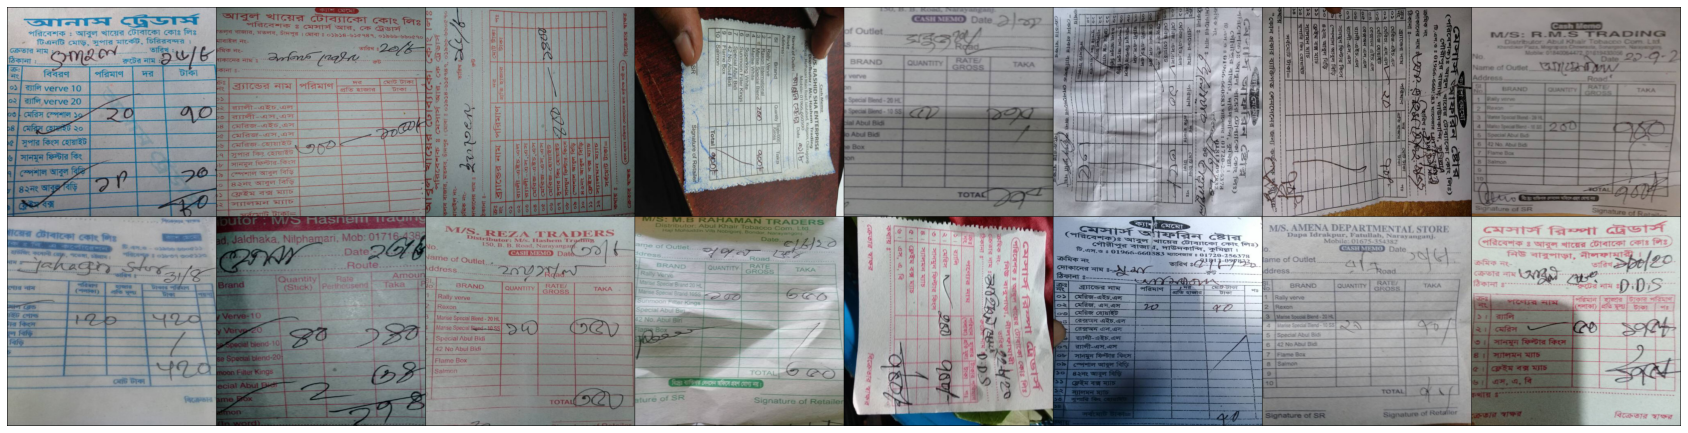

In [11]:
# Load train data and test data
train_data = ImageFolder(root=train_dir, transform=train_transform)
validate_data = ImageFolder(root=test_dir, transform=transform)

# Store data in ImageFolder to DataLoader
train_ds = DataLoader(train_data,batch_size,  shuffle=True, pin_memory=True, num_workers=num_workers)
validate_ds = DataLoader(validate_data,batch_size, shuffle=True, pin_memory=True, num_workers=num_workers)

# View train dataset size
print("Train dataset has {0} images".format(len(train_data)))

# View valid dataset size
print("Validation dataset has {0} images".format(len(validate_data)))

# View image size and class
fst_img, fst_lbl = train_data[0]
print("First image has size: {0} and class: {1}.".format(fst_img.shape, fst_lbl))

sc_img, sc_lbl = train_data[3000]
print("Another random image has size: {0} and class: {1}.".format(sc_img.shape, sc_lbl))

# View all classes
classes = train_data.classes
print("There are {0} classes in total: ".format(len(classes)))
print(classes)

for images, _ in validate_ds:
    print('images.shape:', images.shape)
    plt.figure(figsize=(30,30))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

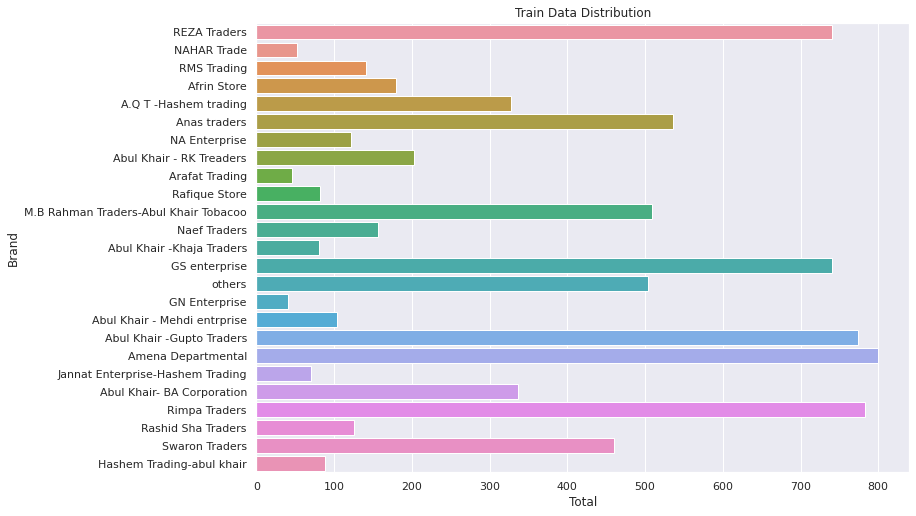

In [12]:
def data_dist_viz(source = '/content/val/',title = "Train Data Distribution"):
    df = pd.DataFrame(columns=['Brand','Total'])
    sourcecpy = source
    brands = os.listdir(source)
    for i in range(len(brands)):
        source = sourcecpy+brands[i]
        onlyfiles = [f for f in os.listdir(source) if os.path.isfile(os.path.join(source, f))]
        data = {'Brand':brands[i], 'Total':len(onlyfiles)}
        df = df.append(data,ignore_index=True)
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.barplot(x = 'Total',
            y = 'Brand',
            data = df).set_title(title)
    
    return df

data = data_dist_viz(source = '/home/apsisdev/mobassir/data/memo_cls/train/Survey_Competition/',title = "Train Data Distribution")      


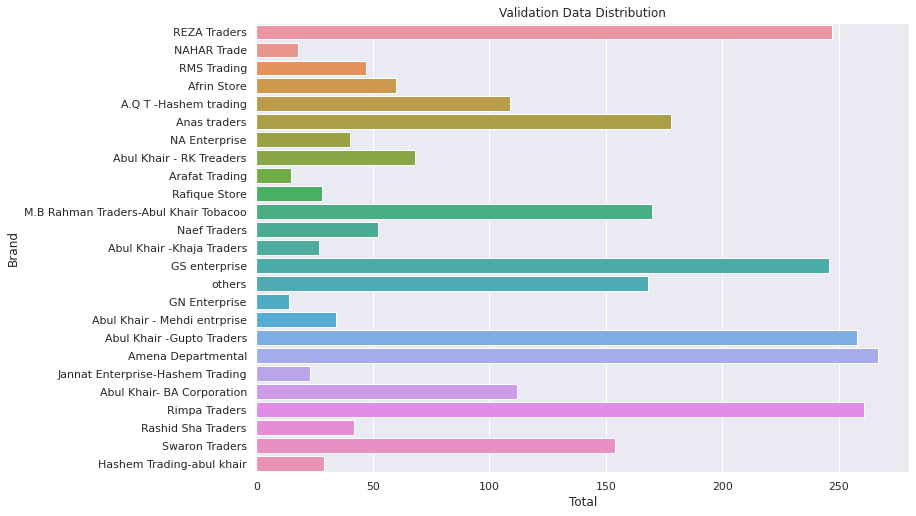

In [13]:

data = data_dist_viz(source = '/home/apsisdev/mobassir/data/memo_cls/val/',title = "Validation Data Distribution")      
   

In [14]:
def get_model(pretrained = True):
    model = models.resnext50_32x4d(pretrained = pretrained)#resnext50_32x4d
#     for q in model.parameters():
#         q.requires_grad = False
    model.fc = nn.Sequential(
      nn.Linear(in_features=model.fc.in_features, out_features=model.fc.in_features//2) ,
      nn.ReLU(),
      nn.Linear(in_features=(model.fc.in_features)//2, out_features=model.fc.in_features//4) ,
      nn.ReLU(),
      nn.Dropout(p=0.6), 
      nn.Linear(in_features=model.fc.in_features//4 , out_features=len(classes)),
      nn.LogSoftmax(dim=1)
    )
    return model


In [15]:
model = get_model(pretrained = True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [16]:

# https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes = len(classes), smoothing=0.0, dim=-1, weight = None):
        """if smoothing == 0, it's one-hot method
           if 0 < smoothing < 1, it's smooth method
        """
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.weight = weight
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        assert 0 <= self.smoothing < 1
        pred = pred.log_softmax(dim=self.dim)

        if self.weight is not None:
            pred = pred * self.weight.unsqueeze(0)   

        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [17]:
# Perform training and cross validation
# Calculate accuracy
def calcAccuracy(scores, label):
    _, prediction = torch.max(scores, dim=1)
    return torch.tensor(torch.sum(prediction == label).item()/len(scores))

#@torch.no_grad()
# Cross validate
def validate(validate_ds, model,softmax):
    model.eval()
    validate_length = 0
    accuracy = 0
    label = []
    preds = []
    for img, lbl in validate_ds:
        with torch.no_grad():
            scores = model(img)
            loss = softmax(scores, lbl)
            lbl = lbl.detach().cpu()
            _, prediction = torch.max(scores, dim=1)
            prediction = prediction.detach().cpu()
            label.append(lbl)
            preds.append(prediction)
            #accuracy += calcAccuracy(scores, lbl)

            
            validate_length += 1
    #accuracy /= validate_length
    print('recall_score = ',metrics.recall_score(np.stack(lbl), np.stack(prediction), average='macro'))
    print('precision_score = ',metrics.precision_score(np.stack(lbl), np.stack(prediction), average='macro'))
    #print('roc_auc_score = ',metrics.roc_auc_score(np.stack(lbl), np.stack(prediction), multi_class='ovr',average='macro'))

    macro = metrics.f1_score(np.stack(lbl), np.stack(prediction), average='macro')
    
    return loss, macro

# Run the training and cross validation
def fit(train_ds, validate_ds, no_epochs, optimizer, model):
    model.train()
    history = []
    softmax = LabelSmoothingLoss(smoothing=0.05) #nn.CrossEntropyLoss(reduction  = 'mean')
    valid_acc = 0
    for index in range(no_epochs):
        # Train
#         if(index<3):
#             for q in model.parameters():
#                 q.requires_grad = False
#         else:
#             for q in model.parameters():
#                 q.requires_grad = True
        model = model.to(device)
        for img, lbl in train_ds:
            scores = model(img)
            loss = softmax(scores, lbl)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validate
        valid_loss, macro = validate(validate_ds, model, softmax)
            
        # Print epoch record
        print(f"Epoch [{index + 1}/{no_epochs}] => loss: {loss}, val_loss: {valid_loss}, Validation F1 Macro: {macro}")
        if(macro > valid_acc):
          print("F1 Macro improved, saving best weight....")
          torch.save(model.state_dict(), '/home/apsisdev/mobassir/data/memo_cls/model.pth')
          valid_acc = macro
        history.append({"loss": loss,
                       "valid_loss": valid_loss,
                       "F1 Macro": macro
                       })
    return history

In [18]:

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class to_GPU():
    def __init__(self, ds, device):
        self.ds = ds
        self.device = device
    
    def __iter__(self):
        for batch in self.ds:
            yield to_device(batch, self.device)

In [19]:
# Initialize model and data before training
device = torch.device('cuda:0')
model = model.to(device)
train_ds = to_GPU(train_ds, device)
validate_ds = to_GPU(validate_ds, device)


In [20]:

# train_ds = DataLoader(train_ds, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
# validate_ds = DataLoader(validate_ds, batch_size, num_workers=num_workers, pin_memory=True)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
if(train):
    history = fit(train_ds, validate_ds, no_epochs, optimizer, model)
    print(history)

recall_score =  0.6
precision_score =  0.4833333333333333
Epoch [1/3] => loss: 1.8733333349227905, val_loss: 1.4992300271987915, Validation F1 Macro: 0.5166666666666666
F1 Macro improved, saving best weight....


/home/apsisdev/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_score =  0.5555555555555556
precision_score =  0.5555555555555556
Epoch [2/3] => loss: 0.762544572353363, val_loss: 0.8900161385536194, Validation F1 Macro: 0.5555555555555556
F1 Macro improved, saving best weight....


/home/apsisdev/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apsisdev/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


recall_score =  1.0
precision_score =  1.0
Epoch [3/3] => loss: 0.40430915355682373, val_loss: 0.45273876190185547, Validation F1 Macro: 1.0
F1 Macro improved, saving best weight....
[{'loss': tensor(1.8733, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(1.4992, device='cuda:0'), 'F1 Macro': 0.5166666666666666}, {'loss': tensor(0.7625, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.8900, device='cuda:0'), 'F1 Macro': 0.5555555555555556}, {'loss': tensor(0.4043, device='cuda:0', grad_fn=<MeanBackward0>), 'valid_loss': tensor(0.4527, device='cuda:0'), 'F1 Macro': 1.0}]


In [22]:
if(train):
    train_loss = []
    valid_loss = []
    macro = []
    for x in history:
        train_loss.append(x["loss"])
        valid_loss.append(x["valid_loss"])
        macro.append(x["F1 Macro"])

    train_loss = [x.item() for x in train_loss]
    valid_loss = [x.item() for x in valid_loss]
    valid_acr = [x.item() for x in macro]
    epochs = np.arange(no_epochs)

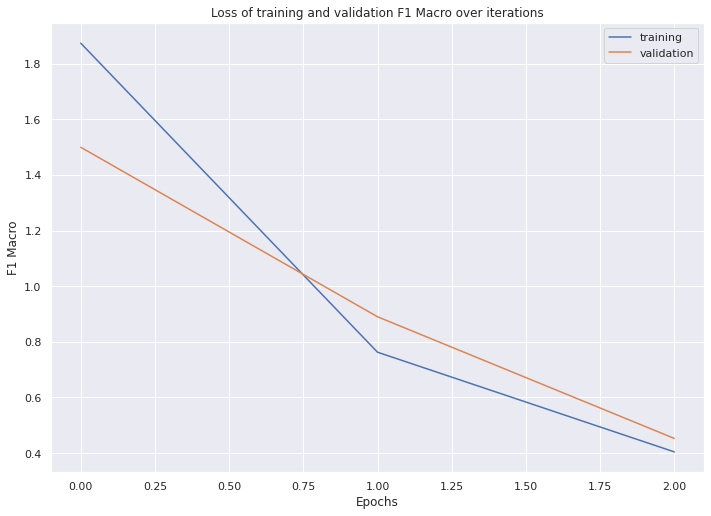

In [23]:
if(train):
    plt.plot(epochs, train_loss)
    plt.plot(epochs, valid_loss)
    plt.xlabel("Epochs")
    plt.ylabel("F1 Macro")
    plt.title("Loss of training and validation F1 Macro over iterations")
    plt.legend(["training", "validation"])
    plt.show()

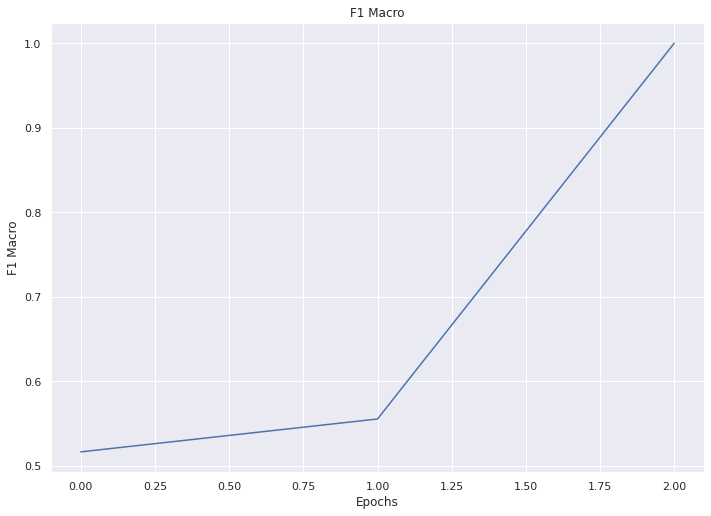

In [24]:
if(train):
    plt.plot(epochs, valid_acr)
    plt.xlabel("Epochs")
    plt.ylabel("F1 Macro")
    plt.title("F1 Macro")
    plt.show()

# Inference

Abul Khair - Mehdi entrprise


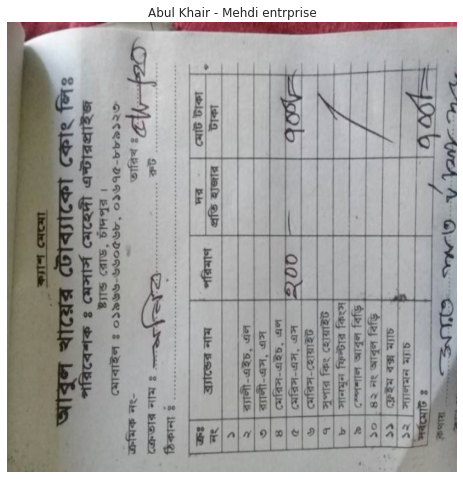

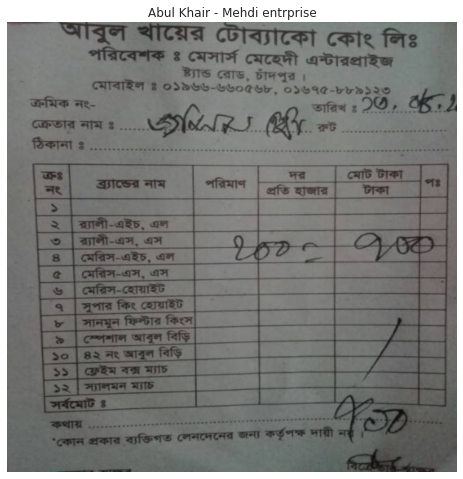

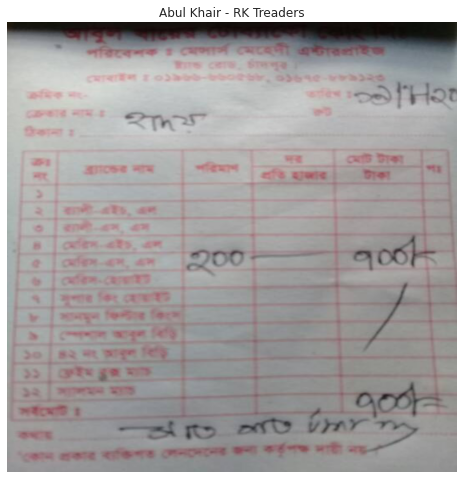

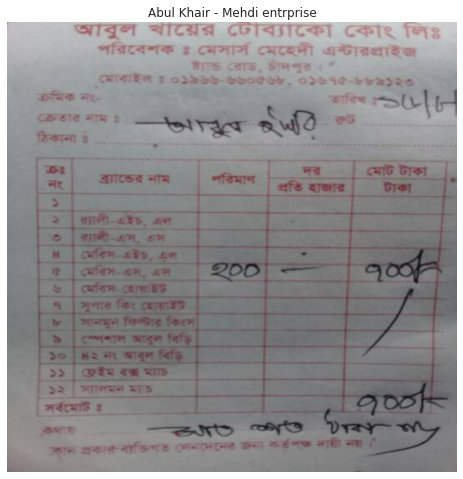

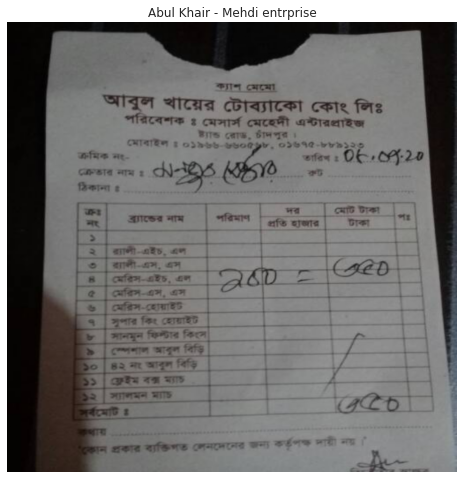

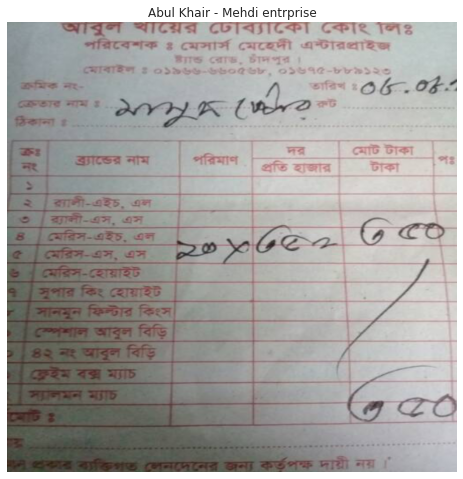

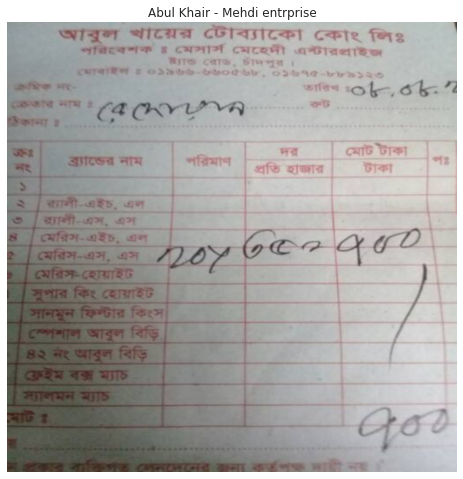

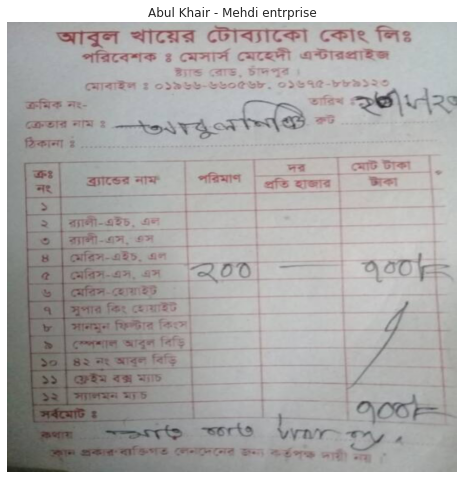

In [25]:
TEST_PATH = '/home/apsisdev/mobassir/data/memo_cls/val/'
brands = os.listdir(TEST_PATH)
index = 16

print(brands[index])
TEST_PATH = TEST_PATH+brands[index]

test_data = []
for i in os.listdir(TEST_PATH):
    img = plt.imread(TEST_PATH + "/" + i).copy()
    test_data.append(transform(img))

test_ds = DataLoader(test_data, pin_memory=True, num_workers=8)
test_ds = to_GPU(test_ds, device)

model = get_model(pretrained = False)

model.load_state_dict(
        torch.load('/home/apsisdev/mobassir/data/memo_cls/model.pth')
    )
model = model.to(device)

model.eval()

predictions = []
count = 0

for img in test_ds:
    scores = model(img)
    _, prediction = torch.max(scores, dim=1)
    predictions.append(prediction.to('cpu').numpy())
    count += 1
    if count == 8:
        break
    
predicted_classes = [classes[x.item()] for x in predictions]

count = 0
for img in test_ds:
    plt.imshow(img[0].to('cpu').permute(1, 2, 0))
    plt.title(predicted_classes[count])
    plt.axis("off")
    plt.show()
    count += 1
    if count == 8:
        break

In [26]:
predictions

[array([1]),
 array([1]),
 array([2]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1])]